# Using SunPy to Analyze Multi-viewpoint Observations
## *Hinode* 14/IRIS 11 Joint Science Meeting - 29 October 2021
### Will Barnes (NRC Postdoc at NRL)
### *with many thanks to: Micah Weberg, Harry Warren, Albert Shih, David Stansby, Stuart Mumford, The SunPy Community*

This tutorial will demonstrate how the `sunpy` core package, along with several affiliated packages as well as the `eispac` software, can be used to analyze an active region as observed by multiple observatories from drastically different viewpoints.

This tutorial will emphasize the three core areas of functionality that `sunpy` provides:

* Data search and download
* Data containers for commonly used data products
* Coordinate transformations and reprojections between solar coordinate systems

Additionally, this tutorial will emphasize how other packages can both utilize and augment the capabilities provided by the `sunpy` core package. In particular, we emphasize the use of level 3 EIS observations in conjunction with other observatories, especially the Extreme Ultraviolet Imager (EUI) on *Solar Orbiter*.

![sunpy](sunpy-summary-slide.png)

In [1]:
import copy

import aiapy
from astropy.coordinates import SkyCoord
import astropy.time
import astropy.units as u
import astropy.wcs
from astropy.visualization import ImageNormalize, quantity_support
import eispac  # This registers the EISMap class
import matplotlib.pyplot as plt
import numpy as np
import pfsspy
from reproject import reproject_interp
import skimage
import sunpy.coordinates
import sunpy.image.coalignment
import sunpy.map
from sunpy.net import Fido,attrs as a
from sunpy.net.attr import and_
import sunpy_soar  # This registers the SOAR Fido client
from sunpy_soar.attrs import Identifier

In [2]:
print('astropy version:', astropy.__version__)
print('sunpy version: ', sunpy.__version__)
print('pfsspy version: ', pfsspy.__version__)

astropy version: 4.3.1
sunpy version:  3.1.0rc1
pfsspy version:  1.0.0


We will load in an EIS observation of the Fe XII 195.119 Å intensity. This data is inlcuded in the `data/` directory, but the `fit-eis-data.py` script shows how to produce these files. Also see Micah's tutorial on the `eispac` software from this morning.

In [3]:
m_eis = sunpy.map.Map('data/eis_fe_xii_195.119_intensity.fits')

Note the `type` of this map instance. The `EISMap` class is automatically registered with sunpy when we import `eispac`. `eispac` is able to provide support for EIS data through the `sunpy` "map factory" without modifying the underlying `sunpy` source code.

In [5]:
type(m_eis)

eispac.core.eismap.EISMap

## Data Search and Download

First, we will search for SDO/AIA and SDO/HMI, STEREO A/SECCHI, and *Solar Orbiter* EUI observations around the time of the EIS raster that we loaded above.

Use of the `near=...` keyword here tells the datasource to return only the observation closests to that date that falls between the dates specified by `start=...` and `end=...`. We will construct four queries in total, one for each instrument, but they will all share a common time search attribute. Note that this capability easily allows to find concurrent observations from multiple observatories.

In [4]:
time_range = a.Time(m_eis.date_start, end=m_eis.date_end, near=m_eis_intensity.date_average)

We can use the `date_start`, `date_end`, and `date_average` properties on our EIS map to construct this query. As of `sunpy` v3.1, these three different times are now exposed as properties to distinguish between the start, end, and middle of the observing period, respectively, as opposed to the singluar `.date` property.

In [5]:
euv_171 = time_range & a.Wavelength(171*u.angstrom) & a.Physobs.intensity
aia_query = euv_171 & a.Instrument.aia
euvi_query = euv_171 & a.Instrument.secchi

In [6]:
hmi_query = time_range & a.Instrument.hmi & a.Physobs.los_magnetic_field

Note here that the interface to the ESA SOAR archive containing the EUI data is provided by the `sunpy_soar` package, external to the core `sunpy` pacakge. Similar to the `EISMap`, we "register" the SOAR client with `Fido` simply by importing `sunpy_soar`.

In [7]:
eui_query = time_range & a.Level(2) & a.Instrument('EUI') & Identifier('EUI-FSI174-IMAGE')

We can now pass all four of these queries to `Fido.search`. Joining them by an **OR** operator `|` tells `Fido.search` that we want four separate results.

In [8]:
q = Fido.search(aia_query | euvi_query | hmi_query | eui_query)

In [9]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x7f17c02d6e50>
Results from 4 Providers:

1 Results from the VSOClient:
       Start Time               End Time        Source ... Extent Type   Size                              Info                          
                                                       ...              Mibyte                                                           
----------------------- ----------------------- ------ ... ----------- -------- ---------------------------------------------------------
2021-04-24 04:47:09.000 2021-04-24 04:47:10.000    SDO ...    FULLDISK 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]

1 Results from the VSOClient:
       Start Time               End Time         Source  Instrument Wavelength [2] ... Wavetype Extent Type   Size              Info            
                                                                       Angstrom    ...                       Mibyte                             
----------------------- ----------------------- -------- ---------- -------------- ... -------- ----------- ------- ----------------------------
2021-04-24 04:09:30.000 2021-04-24 04:09:38.000 STEREO_A     SECCHI 171.0 .. 175.0 ...   NARROW    FULLDISK 8.02002 EUVI ;  ; NORMAL ; 2048x2048

1 Results from the VSOClient:
       Start Time               End Time        Source Instrument  Wavelength [2]  ... Extent Length Extent Type   Size          Info       
                                                                      Angstrom     ...                            Mibyte                    
----------------------- ----------------------- ------ ---------- ---------------- ... ------------- ----------- -------- ------------------
2021-04-24 04:47:03.000 2021-04-24 04:47:04.000    SDO        HMI 6173.0 .. 6174.0 ...          4096    FULLDISK -0.00098 45sec. Magnetogram

1 Results from the SOARClient:
Instrument   Data product   Level        Start time               End time        Filesize
---------- ---------------- ----- ----------------------- ----------------------- --------
       EUI EUI-FSI174-IMAGE    L2 2021-04-24 04:46:43.347 2021-04-25 04:46:43.347  35.6 MB

As expected, we get four results back, three from the VSO (for AIA, STEREO, and HMI) and one from the SOAR archive (for EUI).

We can now pass our resulting query to `Fido.fetch` to download the data. By default, this will be downloaded to `~/sunpy/data`, but we can redirect it using the `path=...` keyword.

In [10]:
files = Fido.fetch(q, path='data/')

Files Downloaded: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75file/s]


In [11]:
files = sorted(files)

In [12]:
files

['/home/wbarnes/sunpy/data/20210424_040930_n4eua.fts',
 '/home/wbarnes/sunpy/data/aia_lev1_171a_2021_04_24t04_47_09_35z_image_lev1.fits',
 '/home/wbarnes/sunpy/data/hmi_m_45s_2021_04_24_04_48_00_tai_magnetogram.fits',
 '/home/wbarnes/sunpy/data/solo_L2_eui-fsi174-image_20210424T044643347_V01.fits']

## Reading Image Data into `Map`

Next, we take the resulting files and create `Map` objects from each of them.

In [13]:
m_euvi, m_aia, m_hmi, m_eui = sunpy.map.Map(files)

We can then easily visualize each of these maps using the `plot` command

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


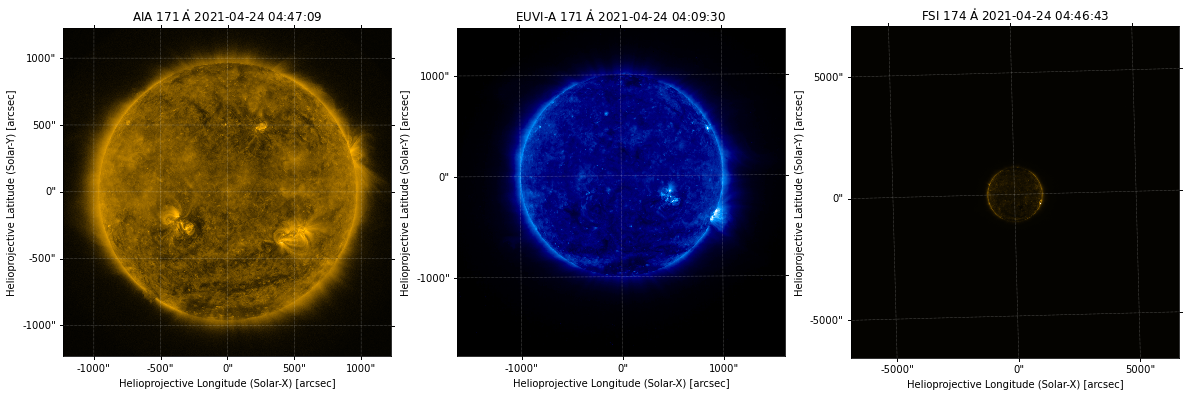

In [15]:
fig = plt.figure(figsize=(20,7.5))
for i,m in enumerate([m_aia, m_euvi, m_eui]):
    ax = fig.add_subplot(1,3,i+1,projection=m)
    m.plot(axes=ax)

Here, show off some of the functionality of `Map`. Demonstrate how observations from many different observatories have the same properties.

### Fixing the EIS Pointing with AIA

Adjust the EIS pointing using a cross-correlation with the AIA 171 Å image.

In [ ]:
n_x = (m_aia.scale.axis1 * m_aia.dimensions.x) / m_eis.scale.axis1
n_y = (m_aia.scale.axis2 * m_aia.dimensions.y) / m_eis.scale.axis2
m_aia_r = m_aia.resample(u.Quantity([n_x, n_y]))
# Cross-correlate 
# The resulting "shifts" can be interpreted as the location of the bottom left pixel of the
# EIS raster in the pixel coordinates of the AIA image. Note that these are in array index
# coordinates.
yshift, xshift = sunpy.image.coalignment.calculate_shift(m_aia_r.data, m_eis.data)
# Find the corresponding coordinate at this pixel position in the resampled AIA map
reference_coord = m_aia_r.pixel_to_world(xshift, yshift)
# Update metadata
# Set the pointing appropriately. Note that FITS WCS is 1-based
meta = copy.deepcopy(m.meta)
# TODO: confirm that this reference coord corresponds to the center of the pixel
# as opposed to the bottom left (0.5,0.5) or top right (1.5,1.5) corner
meta['crpix1'] = 1
meta['crpix2'] = 1
meta['crval1'] = ref_coord.Tx.to('arcsec').value
meta['crval2'] = ref_coord.Ty.to('arcsec').value
eis_maps_fixed.append(m._new_instance(m.data, meta))

In [16]:
m_eis_intensity_fixed, m_eis_velocity_fixed, m_eis_width_fixed = fix_eis_pointing([m_eis_intensity, m_eis_velocity, m_eis_width], m_aia)

We can see the difference by overplotting the AIA 171 intensity

(-0.5, 122.5, -0.5, 511.5)

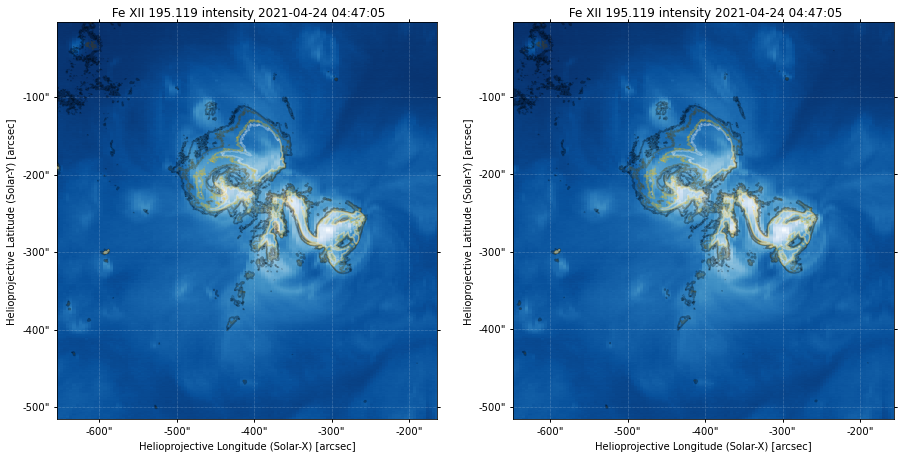

In [17]:
levels = [400,500,700,800]*m_aia.unit
fig = plt.figure(figsize=(15,7.5))
ax = fig.add_subplot(121, projection=m_eis_intensity)
m_eis_intensity.plot(axes=ax)
bounds = ax.axis()
m_aia.draw_contours(levels, axes=ax, cmap='sdoaia171', alpha=0.3)
ax.axis(bounds)
ax = fig.add_subplot(122, projection=m_eis_intensity_fixed)
m_eis_intensity_fixed.plot(axes=ax)
bounds = ax.axis()
m_aia.draw_contours(levels, axes=ax, cmap='sdoaia171', alpha=0.3)
ax.axis(bounds)

In [18]:
print(m_eis_intensity.center.Tx - m_eis_intensity_fixed.center.Tx)
print(m_eis_intensity.center.Ty - m_eis_intensity_fixed.center.Ty)

-7.3411arcsec
0.550903arcsec


### Cropping to a Common Field of View

The advantage of having observations of a single active region from multiple observatories is that we can see the resulting structures from multiple viewpoints. We can use the metadata from each map to visualize the relative locations of the three observatories. The locations of SDO and *Hinode* lie directly on top of one another, as expected. 

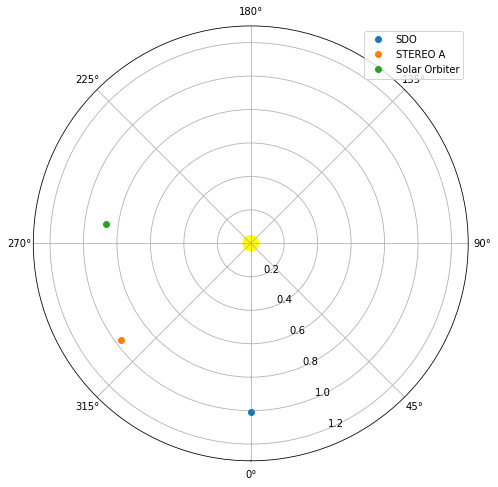

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')
# Plot the Sun
circle = plt.Circle((0.0, 0.0), (10*u.Rsun).to_value(u.AU),
                    transform=ax.transProjectionAffine + ax.transAxes, color="yellow",
                    alpha=1, label="Sun")
ax.add_artist(circle)
# Plot the satellite locations
for m in [m_eis, m_aia, m_euvi, m_eui]:
    sat = m.observatory
    coord = m.observer_coordinate
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU), 'o', label=sat)
# Add a few things
ax.set_theta_zero_location("S")
ax.set_rlim(0, 1.3)
ax.legend()

Now, let's crop all of the maps to the (adjusted) EIS FOV in order to see the different views of the active region offered by the different observatories.

We construct the cropped maps by calculating the width and height of the EIS raster, transforming the center coordinate of the EIS raster to the coordinate frame of each observation, and then calculating the bottom left coordinate from this transformed coordinate

In [ ]:
eis_fov_width = m_eis_intensity_fixed.dimensions.x * m_eis_intensity_fixed.scale.axis1
eis_fov_height = m_eis_intensity_fixed.dimensions.y * m_eis_intensity_fixed.scale.axis2

In [155]:
cropped_maps = []
for m in [m_aia, m_eui, m_euvi]:
    center = m_eis_intensity_fixed.center.transform_to(m.coordinate_frame)
    blc = SkyCoord(center.Tx-eis_fov_width/2, center.Ty-eis_fov_height/2, frame=center.frame)
    cropped_maps.append(m.submap(blc, width=eis_fov_width, height=eis_fov_height))
m_aia_cropped, m_eui_cropped, m_euvi_cropped = cropped_maps

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


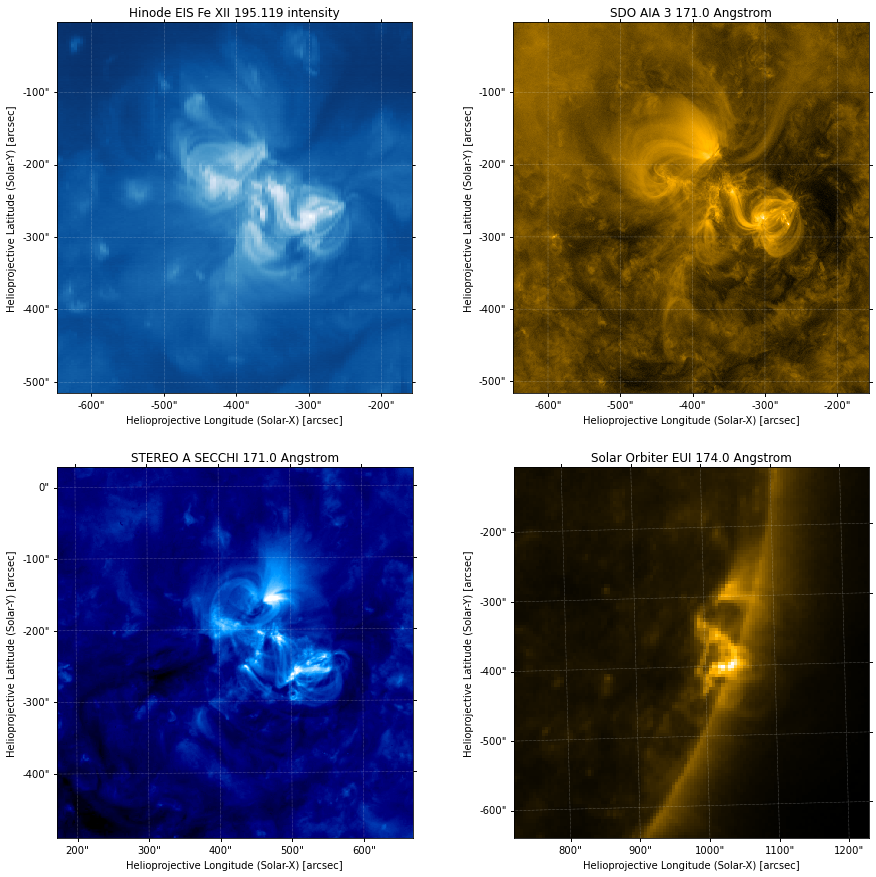

In [156]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_intensity_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')

## Reprojection and Field Extrapolation

We want to do construct a model of the 3D magnetic field for this active region. We can do this using the corresponding HMI LOS magnetic field observation and the `pfsspy` package.

In [77]:
shape_out=[540, 1080]
frame_out = SkyCoord(0, 0, unit=u.deg, frame="heliographic_stonyhurst", obstime=m_hmi.date)
header = sunpy.map.make_fitswcs_header(
    shape_out,
    frame_out,
    scale=[180 / shape_out[0], 360 / shape_out[1]] * u.deg / u.pix,
    projection_code="CAR",
)
out_wcs = astropy.wcs.WCS(header)
array, _ = reproject_interp(m_hmi, out_wcs, shape_out=shape_out)
array = np.where(np.isnan(array), 0, array)
m_hmi_cea = pfsspy.utils.car_to_cea(sunpy.map.Map(array, header))
m_hmi_cea.meta['TELESCOP'] = m_hmi.meta['TELESCOP']
m_hmi_cea.meta['CONTENT'] = 'Carrington Synoptic Chart Of Br Field'
m_hmi_cea = sunpy.map.Map(
    m_hmi_cea.data,
    m_hmi_cea.meta,
    plot_settings={'norm': ImageNormalize(vmin=-1.5e3,vmax=1.5e3), 'cmap': 'hmimag'}
)

/home/wbarnes/anaconda3/envs/sunpy-hinode-iris-21/lib/python3.9/site-packages/sunpy/util/decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


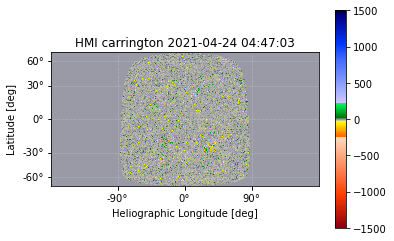

In [78]:
m_hmi_cea.peek()

In [79]:
nrho = 70
rss = 2.5
input = pfsspy.Input(m_hmi_cea, nrho, rss)
output = pfsspy.pfss(input)
m_hmi_cea.plot_settings = {'norm': ImageNormalize(vmin=-1.5e3,vmax=1.5e3), 'cmap': 'hmimag'}

**Word of Caution:** We are performing the field extrapolation on a synoptic map created by reprojecting a LOS magnetogram. While this is likely to provide a decent estimate of the local, AR-scale field structure, this method will not adequately capture the global structure of the coronal magnetic field. To compute a more accurate representation of the global coronal field, one should use a true synoptic magnetogram instead.

## Field Extrapolation and Fieldline Coordinates

In [80]:
masked_pix_y, masked_pix_x = np.where(m_hmi_cea.data < -3e1)
seeds = m_hmi_cea.pixel_to_world(masked_pix_x*u.pix, masked_pix_y*u.pix,).make_3d()

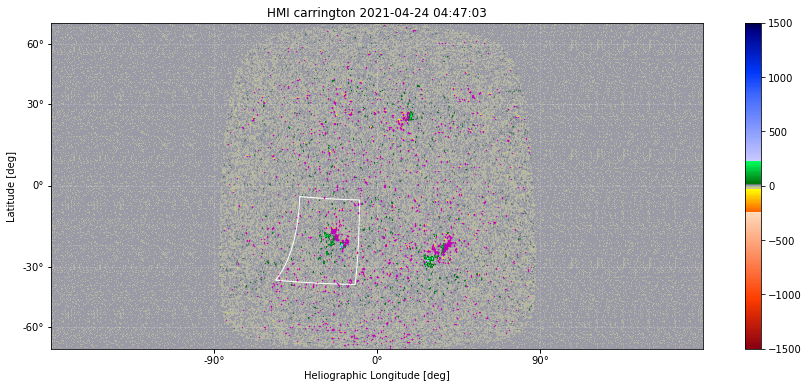

In [81]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111,projection=m_hmi_cea)
m_hmi_cea.plot(axes=ax,)
ax.plot_coord(seeds, marker='.', color='m', markersize=1, ls='')
m_hmi_cea.draw_quadrangle(m_eis_intensity_fixed.bottom_left_coord, top_right=m_eis_intensity_fixed.top_right_coord)
plt.colorbar()

We want to find only those seed points that fall inside the EIS FOV

In [82]:
seeds_hpc = seeds.transform_to(m_eis_intensity_fixed.coordinate_frame)
in_lon = np.logical_and(seeds_hpc.Tx > m_eis_intensity_fixed.bottom_left_coord.Tx,
                        seeds_hpc.Tx < m_eis_intensity_fixed.top_right_coord.Tx)
in_lat = np.logical_and(seeds_hpc.Ty > m_eis_intensity_fixed.bottom_left_coord.Ty,
                        seeds_hpc.Ty < m_eis_intensity_fixed.top_right_coord.Ty)
seeds_eis = seeds[np.where(np.logical_and(in_lon, in_lat))]

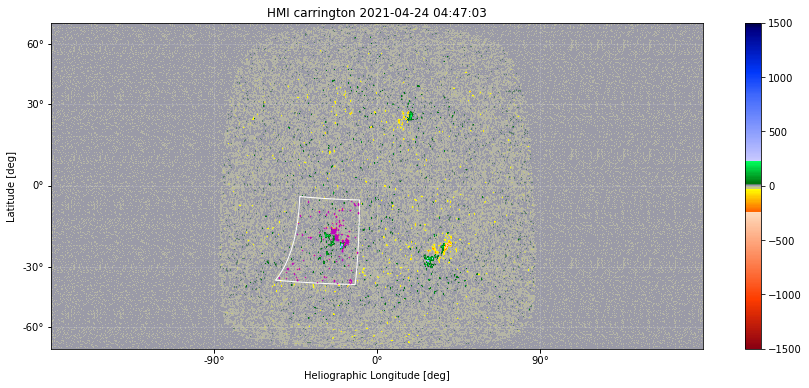

In [83]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111,projection=m_hmi_cea)
m_hmi_cea.plot(axes=ax,)
ax.plot_coord(seeds_eis, marker='.', color='m', markersize=1, ls='')
m_hmi_cea.draw_quadrangle(m_eis_intensity_fixed.bottom_left_coord, top_right=m_eis_intensity_fixed.top_right_coord)
plt.colorbar()

Finally, we can trace fieldlines from these seedpoints.

In [84]:
tracer = pfsspy.tracing.FortranTracer()

In [85]:
fieldlines = tracer.trace(SkyCoord(seeds_eis), output,)

## Projecting Fieldlines Onto Images

In [86]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

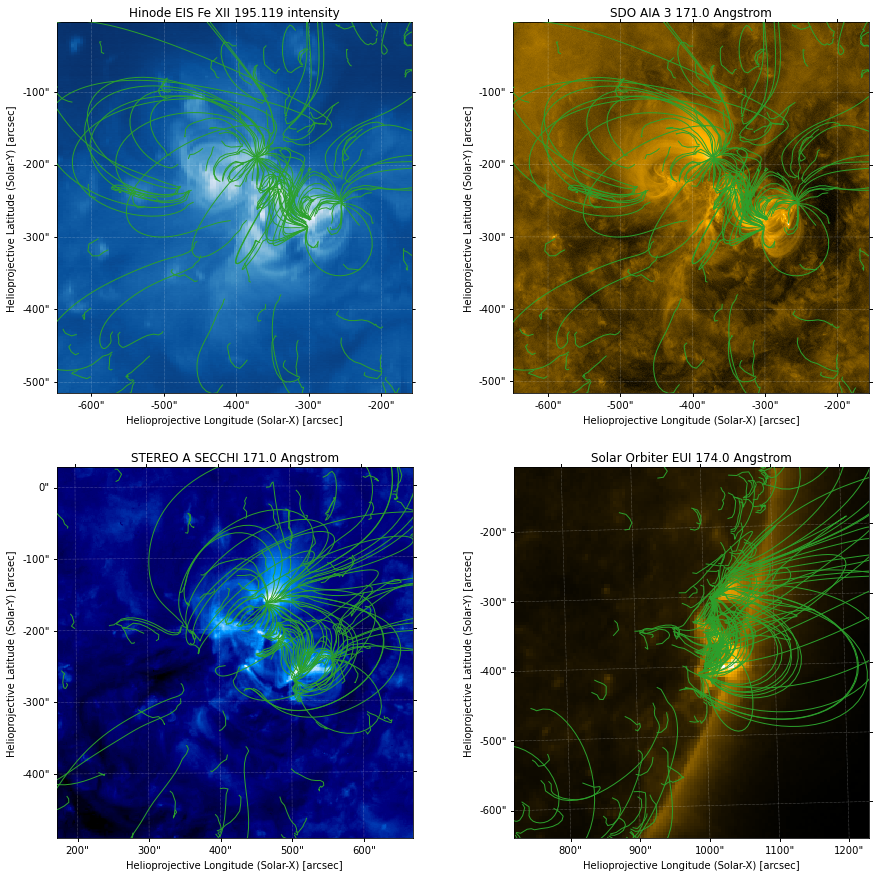

In [157]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_intensity_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
    bounds = ax.axis()
    for f in fieldlines:
        if get_loop_length(f) > 20 * u.Mm:
            ax.plot_coord(f.coords, ls='-', lw=1, color='C2', alpha=1)
    ax.axis(bounds)

## Optional: Extracting Intensity Data Along Fieldlines

Select a loop near that roughly traces an intensity enhancement near the core of our active region as observed by EIS and AIA

In [158]:
loop_coord = fieldlines[180].coords

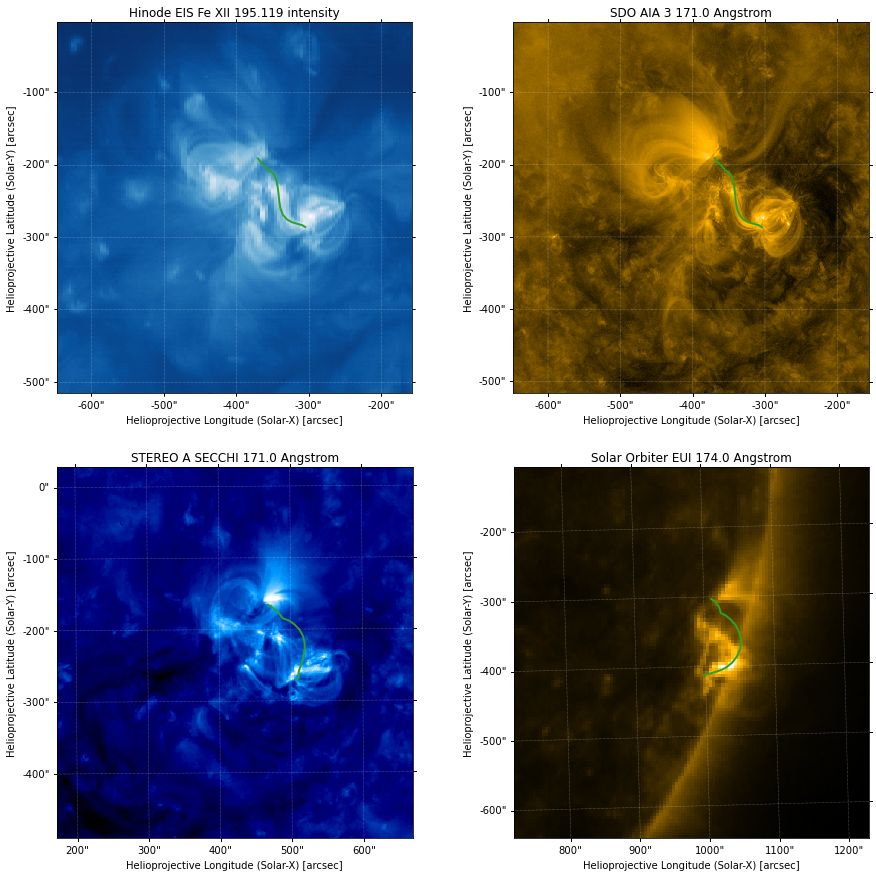

In [159]:
fig = plt.figure(figsize=(15,15))
for i,m in enumerate([m_eis_intensity_fixed, m_aia_cropped, m_euvi_cropped, m_eui_cropped]):
    ax = fig.add_subplot(2,2,i+1,projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
    bounds = ax.axis()
    ax.plot_coord(loop_coord, ls='-', lw=2, color='C2', alpha=1)
    ax.axis(bounds)

Define some functions that help to identify pixels corresponding to coordinates

In [167]:
def bresenham(x1, y1, x2, y2):
    """
    Returns an array of all pixel coordinates which the line defined by `x1, y1` and
    `x2, y2` crosses. Uses Bresenham's line algorithm to enumerate the pixels along
    a line. This was adapted from ginga

    Parameters
    ----------
    x1, y1, x2, y2 :`int`

    References
    ----------
    | https://github.com/ejeschke/ginga/blob/master/ginga/BaseImage.py#L387
    | http://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    | https://ginga.readthedocs.org/en/latest/
    """
    for x in [x1, y1, x2, y2]:
        if type(x) not in (int, np.int64):
            raise TypeError('All pixel coordinates must be of type int')
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy
    res = []
    x, y = x1, y1
    while True:
        res.append((x, y))
        if (x == x2) and (y == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err - dy
            x += sx
        if e2 <  dx:
            err = err + dx
            y += sy
    return np.array(res)


def get_intersecting_pixels(coord, image_wcs):
    # Find pixels between each loop segment
    px, py = image_wcs.world_to_pixel(coord)
    px = np.round(px).astype(int)
    py = np.round(py).astype(int)
    loop_pix = []
    for i in range(px.shape[0]-1):
        b = bresenham(px[i], py[i], px[i+1], py[i+1])
        # Pop the last one, unless this is the final entry because the first point
        # of the next section will be the same
        if i < px.shape[0]-2:
            b = b[:-1]
        loop_pix.append(b)
    return np.vstack(loop_pix)

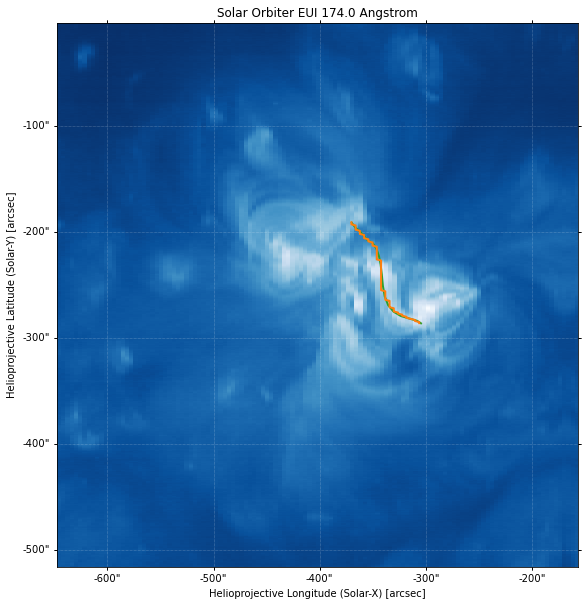

In [174]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=m_eis_intensity_fixed)
m_eis_intensity_fixed.plot(axes=ax, title=f'{m.observatory} {m.instrument} {m.measurement}')
ax.plot_coord(loop_coord, ls='-', lw=2, color='C2', alpha=1)
pix = get_intersecting_pixels(loop_coord,m_eis_intensity_fixed.wcs)
ax.plot(pix[:,0], pix[:,1], ls='-', lw=2, color='C1', alpha=1)

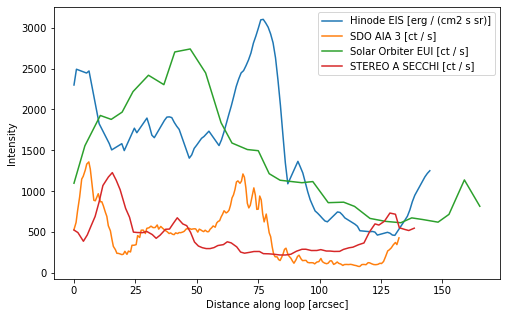

In [195]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
for m in [m_eis_intensity_fixed, m_aia_cropped, m_eui_cropped, m_euvi_cropped]:
    pix = get_intersecting_pixels(loop_coord, m.wcs)
    intensity = m.data[pix[:,1],pix[:,0]] * m.unit
    if intensity.unit == u.count:
        intensity = intensity / m.exposure_time
    c = m.pixel_to_world(pix[:,0]*u.pix,pix[:,1]*u.pix)
    data = u.Quantity([c.Tx, c.Ty]).to('arcsec').value
    loop_s = np.append(0., np.linalg.norm(np.diff(data, axis=1), axis=0).cumsum()) #* u.arcsec
    ax.plot(loop_s, intensity,label=f'{m.observatory} {m.instrument} [{intensity.unit}]')
ax.set_xlabel('Distance along loop [arcsec]')
ax.set_ylabel(f'Intensity')
ax.legend()